In [7]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch import nn
import torch


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

backbone = resnet_fpn_backbone("resnet50", pretrained=True,)
model = fasterrcnn_resnet50_fpn(backbone)

c:\Users\Raul\miniconda3\envs\aidl-project2\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\Raul\miniconda3\envs\aidl-project2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Raul\miniconda3\envs\aidl-project2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Raul\miniconda3\envs\aidl-project2\Lib\site-packa

In [11]:
class TwoMLPHead(nn.Module):
    """
    Standard heads for FPN-based models

    Arguments:
        in_size (int): number of inputs
        representation_size (int): size of the intermediate representation
    """

    def __init__(self, in_size, representation_size):
        super(TwoMLPHead, self).__init__()

        self.fc6 = nn.Linear(in_size, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        x = self.fc6(x)
        x = nn.functional.relu(x)   
        x = self.fc7(x)
        x = nn.functional.relu(x)
        # Note: the original code does not apply a final activation function

        return x

In [12]:
class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Arguments:
        in_size (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_size, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_size, num_classes)
        self.bbox_pred = nn.Linear(in_size, 4 * num_classes)

    def forward(self, x):
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

In [19]:
in_size = 256*7*7
representation_size = 1024
num_classes = 3
model.roi_heads.box_head = TwoMLPHead(in_size, representation_size)
model.roi_heads.box_predictor = FastRCNNPredictor(representation_size, num_classes)

C:\Users\Raul\AppData\Local\Temp\tmpldr25g1p


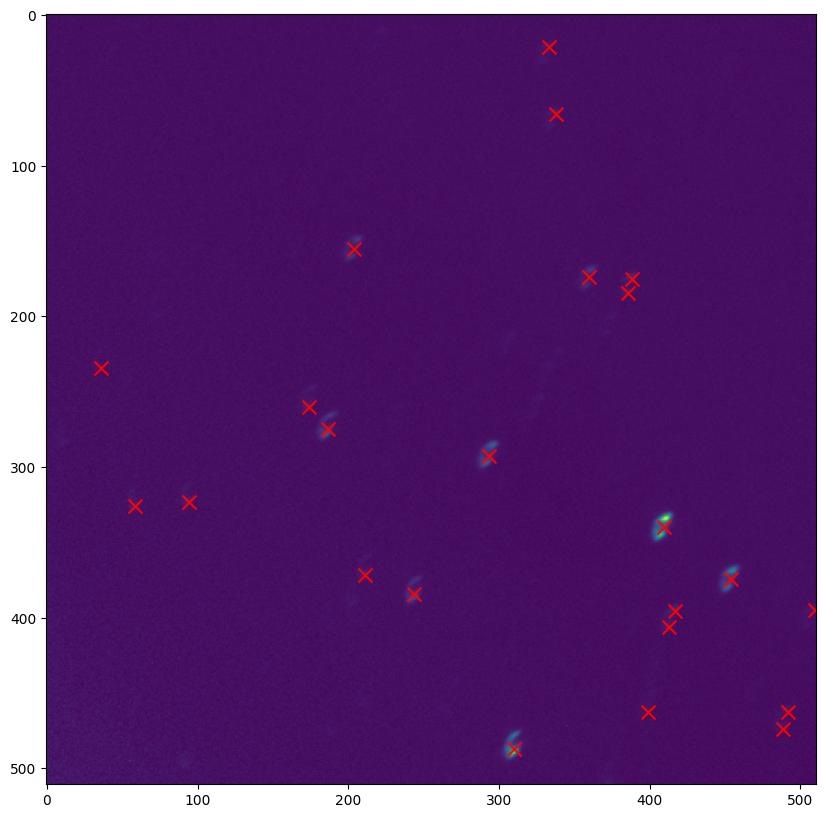

In [65]:
from dataset.telescope_dataset import TelescopeDataset
from torchvision import transforms
import tempfile
from matplotlib import pyplot as plt
import numpy as np

data_transforms = transforms.Compose([transforms.ToTensor()])
with tempfile.TemporaryDirectory() as tempdir:
    print(tempdir)
    joan_oro_dataset = TelescopeDataset(data_path = "../dataset", cache_dir=tempdir, transform=data_transforms)
    im, targets = joan_oro_dataset.__getitem__(7)



    # Convert list of dicts to structured numpy array
    targets_array = np.array([
        [t['x_center'], t['y_center'], t['width'], t['height'], t['class_id']]
        for t in targets
    ])
    plt.figure(figsize=(10, 10))
    plt.imshow(im.permute(1, 2, 0).numpy())
    plt.scatter(targets_array[:,0]*512, targets_array[:,1]*512, s=100, c='r', marker='x')

In [86]:
len([to_tensor(np.asarray(im))])

1

In [87]:
from torchvision.transforms.functional import to_tensor


transformed, _ = model.transform([to_tensor(np.asarray(im))], None)
# feature_maps = model.backbone(transformed.tensors)
# print({k: v.shape for k, v in feature_maps.items()})

RuntimeError: The size of tensor a (511) must match the size of tensor b (3) at non-singleton dimension 0

In [ ]:
from torchvision.transforms.functional import to_tensor
x = to_tensor(im).to(device)
targets = None